<a href="https://colab.research.google.com/github/AbhinavaReddy-hub/learning-DL-/blob/main/RNN_Many_to_One_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Google Stock Prices Using RNN in PyTorch
In this exercise, you will build and train a RNN network to predict Google stock prices based on historical data. You will process the data, design an RNN model, and evaluate its performance by comparing the predicted stock prices with the actual prices.

# 1. Data Preparation

##         1.Import Necessary libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 2.  Load dataset

In [3]:
# Load dataset
data = pd.read_csv('Google_Stock_Price.csv')  # Replace with your file path
prices = data['Open'].values.reshape(-1, 1)
print(prices)

[[325.25]
 [331.27]
 [329.83]
 ...
 [793.7 ]
 [783.33]
 [782.75]]


In [4]:
data.shape

(1258, 6)

##  3. Data normalization

In [5]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)
print(prices_scaled)

[[0.08581368]
 [0.09701243]
 [0.09433366]
 ...
 [0.95725128]
 [0.93796041]
 [0.93688146]]


## 4.Prepare sequences

In [6]:
# Prepare sequences
sequence_length=60
def create_sequence(data,sequence_length):
    X=[]
    y=[]
    for i in range(len(data)-sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X),np.array(y)
X,y=create_sequence(prices_scaled,sequence_length)
print(X.shape,X)
print(y.shape,y)

(1198, 60, 1) [[[0.08581368]
  [0.09701243]
  [0.09433366]
  ...
  [0.07846566]
  [0.08034452]
  [0.08497656]]

 [[0.09701243]
  [0.09433366]
  [0.09156187]
  ...
  [0.08034452]
  [0.08497656]
  [0.08627874]]

 [[0.09433366]
  [0.09156187]
  [0.07984225]
  ...
  [0.08497656]
  [0.08627874]
  [0.08471612]]

 ...

 [[0.92106928]
  [0.92438053]
  [0.93048218]
  ...
  [0.95475854]
  [0.95204256]
  [0.95163331]]

 [[0.92438053]
  [0.93048218]
  [0.9299055 ]
  ...
  [0.95204256]
  [0.95163331]
  [0.95725128]]

 [[0.93048218]
  [0.9299055 ]
  [0.93113327]
  ...
  [0.95163331]
  [0.95725128]
  [0.93796041]]]
(1198, 1) [[0.08627874]
 [0.08471612]
 [0.07454052]
 ...
 [0.95725128]
 [0.93796041]
 [0.93688146]]


## 5. Train-test split

Purpose of Train-Test Split:
Training Set: Used to train the LSTM model.
Testing Set: Used to evaluate the model's performance on unseen data.A typical split is 80% training and 20% testing.

Split the input (X) and output (y) into
X_train and y_train: For training
X_test and y_test: For testing
and Convert X_train, X_test, y_train, and y_test to tensors using torch.tensor().


In [7]:
# Train-test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

## 6.Reshape for RNN input

In [ ]:
Purpose of Reshaping:
RNNs, including LSTMs, require input data to be in a specific 3D tensor format:(n_samples,sequence_length,n_features)
n_samples: Number of sequences in the dataset.
sequence_length: Length of each sequence (e.g., 60 timesteps).
n_features: Number of features per timestep (e.g., 1 for stock prices).

The current shape of X_train and X_test is 2D:(n_samples,sequence_length)
We need to add a third dimension for n_features to indicate that each timestep has only one feature.

Steps to Reshape Data:
Use PyTorch's .view() method to reshape the tensors.
Maintain the batch size (n_samples) and sequence length while adding an additional dimension for features.


In [8]:
# Reshape for RNN input
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

<ipython-input-8-8abbc9bdd6b8>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
<ipython-input-8-8abbc9bdd6b8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


# 2. RNN Model Building

## 1.Defining the RNN Model

In [9]:
# Define RNN model
class RNN (nn.Module):
    def __init__(self,input_size=1,hidden_size=64,num_layers=2):
        super(RNN,self).__init__()
        self.rnn=nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,1)
    def forward(self,x):
        rnn_output,_=self.rnn(x)
        output=self.fc(rnn_output[:,-1,:])
        return output
model=RNN()

In [10]:
model

RNN(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## 2.Initializing the Model, Loss Function, and Optimizer

You are tasked with building an RNN model to predict Google stock prices. Implement the following steps:

Define an RNN model (StockPriceRNN) that takes in the past 60 days' stock prices to predict the next day's price.
Set up the loss function using Mean Squared Error (MSE) for the regression task.
Initialize the Adam optimizer with a learning rate of 0.001 to optimize the model parameters.
Use the defined model(model), loss function(criterion), and optimizer(optimizer) to train the model on the stock price dataset.

In [11]:
import torch.optim as optim

In [12]:
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

## 3.Training the model

In [13]:
# Training loop
# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 10/50, Loss: 0.0449
Epoch 20/50, Loss: 0.0084
Epoch 30/50, Loss: 0.0011
Epoch 40/50, Loss: 0.0017
Epoch 50/50, Loss: 0.0011


# 3. Evaluate the Model

In [14]:
# Testing
model.eval()
with torch.no_grad():
    predictions = model(X_test).detach().numpy()
    #y_test = y_test.numpy()

# 4. Plot results

In [ ]:
After testing the model, you need to rescale the predicted and actual stock prices back to the original scale and visualize the results. The steps are:

Rescale the Predictions and Actual Values:
convert the predictions and the actual values (y_test) back from the scaled range [0, 1] to the original stock price values

Plot the Results

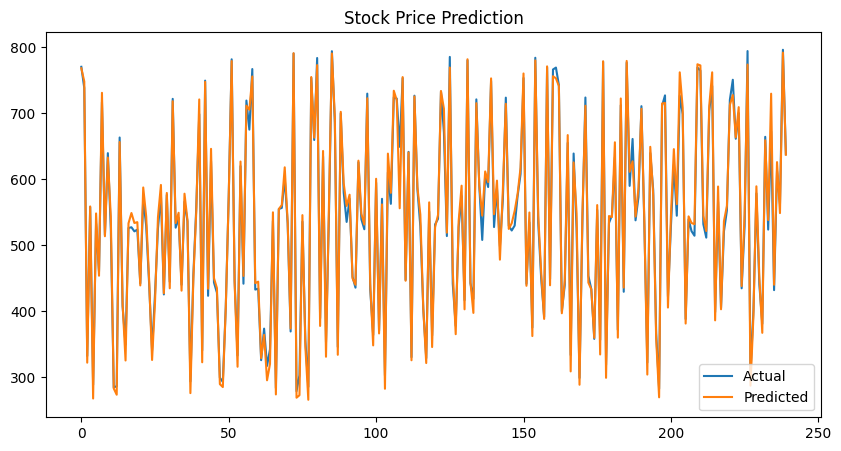

In [15]:
# Rescale predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("Stock Price Prediction")
plt.show()


# 5.Predict on a new sample

In [16]:
# Predict on a new sample
sample_sequence = prices[-60:]  # Use the last 60 days as an example
sample_sequence_scaled = scaler.transform(sample_sequence)

# Convert to tensor and reshape for the model
sample_tensor = torch.tensor(sample_sequence_scaled, dtype=torch.float32).view(1, sequence_length, 1)

# Make prediction
model.eval()
with torch.no_grad():
    predicted_scaled = model(sample_tensor).item()

# Inverse transform to get the actual predicted price
predicted_price = scaler.inverse_transform([[predicted_scaled]])[0][0]

# The actual value (next day's price)
actual_price = prices[-1]  # Replace this with the actual value if available

print(f"Actual Stock Price: {actual_price[0]:.2f}")
print(f"Predicted Stock Price: {predicted_price:.2f}")


Actual Stock Price: 782.75
Predicted Stock Price: 786.78
